In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

In [2]:
# loans = fred.get_series("CCLACBW027SBOG").rename("loans")
loans = pd.read_csv("consumerloans_clean.csv", index_col=0, parse_dates=True).rename(
    columns={"consumerloans": "loans"}
)
claims = fred.get_series("ICSA").rename("claims")  # Weekly
eff_funds = fred.get_series("FF").rename("eff_funds")  # Weekly
deposits = fred.get_series("DPSACBW027SBOG").rename("deposits")  # Weekly

arimax_df = pd.DataFrame(loans)
for s in [eff_funds, deposits]:
    arimax_df = pd.merge_asof(arimax_df, s, left_index=True, right_index=True)
arimax_df[["eff_funds_l1", "deposits_l1"]] = (
    arimax_df[["eff_funds", "deposits"]].shift(1).bfill()
)
arimax_df["deposits_l1_log_ret"] = np.log(arimax_df["deposits_l1"]).diff().bfill()

In [3]:
arimax_df

,loans,eff_funds,deposits,eff_funds_l1,deposits_l1,deposits_l1_log_ret
date,,,,,,
2000-06-28,551.643510,6.53,3576.1524,6.53,3576.1524,0.000000
2000-07-05,554.377885,6.85,3625.4808,6.53,3576.1524,0.000000
2000-07-12,553.241385,6.44,3613.4882,6.85,3625.4808,0.013699
2000-07-19,554.903785,6.50,3619.9306,6.44,3613.4882,-0.003313
2000-07-26,554.138385,6.50,3639.3521,6.50,3619.9306,0.001781
...,...,...,...,...,...,...
2024-03-13,1053.400000,5.33,17535.5968,5.33,17494.1022,0.002918
2024-03-20,1054.565700,5.33,17568.9661,5.33,17535.5968,0.002369
2024-03-27,1053.803300,5.33,17645.4336,5.33,17568.9661,0.001901


In [4]:
p = q = range(7)
arimax_models = np.empty((len(p), len(q)), dtype=object)
arimax_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arimax = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
            exog=arimax_df[["eff_funds_l1", "deposits_l1_log_ret"]],
        )
        arimax_models[ar_lags, ma_lags] = arimax
        arimax_results[ar_lags, ma_lags] = arimax.fit()
arimax_aics = np.array(list(map(lambda r: r.aic, arimax_results.flatten()))).reshape(
    len(p), len(q)
)
arimax_aics = pd.DataFrame(arimax_aics, index=p, columns=q)

100%|██████████| 7/7 [01:53<00:00, 16.17s/it]


In [5]:
arima_models = np.empty((len(p), len(q)), dtype=object)
arima_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arima = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
        )
        arima_models[ar_lags, ma_lags] = arima
        arima_results[ar_lags, ma_lags] = arima.fit()
arima_aics = np.array(list(map(lambda r: r.aic, arima_results.flatten()))).reshape(
    len(p), len(q)
)
arima_aics = pd.DataFrame(arima_aics, index=p, columns=q)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:56<00:00,  8.09s/it]


In [26]:
arima_aics

In [27]:
arimax_aics

In [8]:
arima_aics.stack().idxmin()

(6, 4)

In [9]:
arimax_aics.stack().idxmin()

(3, 6)

In [10]:
arimax_results[3, 6].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  loans   No. Observations:                 1242
Model:                 ARIMA(3, 1, 6)   Log Likelihood               -2755.680
Date:                Thu, 25 Apr 2024   AIC                           5535.361
Time:                        16:11:34   BIC                           5596.845
Sample:                    06-28-2000   HQIC                          5558.483
                         - 04-10-2024                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
eff_funds_l1            1.4951      0.464      3.224      0.001       0.586       2.404
deposits_l1_log_ret   -37.0718      5.197     -7.134      0.000     -47.257     -26.887
ar.L1                   1.2138      0.015     79.085      0.000       1.184       1.244
ar.L2                  -1.2371      0.005   -247.044      0.000      -1.247      -1.227
ar.L3                   0.9636      0.015     63.420      0.000       0.934       0.993
ma.L1                  -1.1312      0.023    -49.845      0.000      -1.176      -1.087
ma.L2                   1.3249      0.034     39.125      0.000       1.259       1.391
ma.L3                  -0.9401      0.045    -21.106      0.000      -1.027      -0.853
ma.L4                   0.0752      0.046      1.646      0.100      -0.014       0.165
ma.L5                  -0.0271      0.033     -0.829      0.407      -0.091       0.037
ma.L6                  -0.0875      0.024     -3.695      0.000      -0.134      -0.041
sigma2                  4.9601      0.129     38.402      0.000       4.707       5.213
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1307.46
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.56
Prob(H) (two-sided):                  0.65   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
exog_forecast = np.zeros((52, 2))

In [12]:
ieffr = pd.read_csv("ieffr.csv")
ieffr.set_index("Date", inplace=True)
exog_forecast[:, 0] = ieffr["Implied EFFR"].values

Main forecast for next 2 years. ARIMAX (3,1,6). Only uses IFFER as exogenous variable. Maybe the plot should be made more pretty.


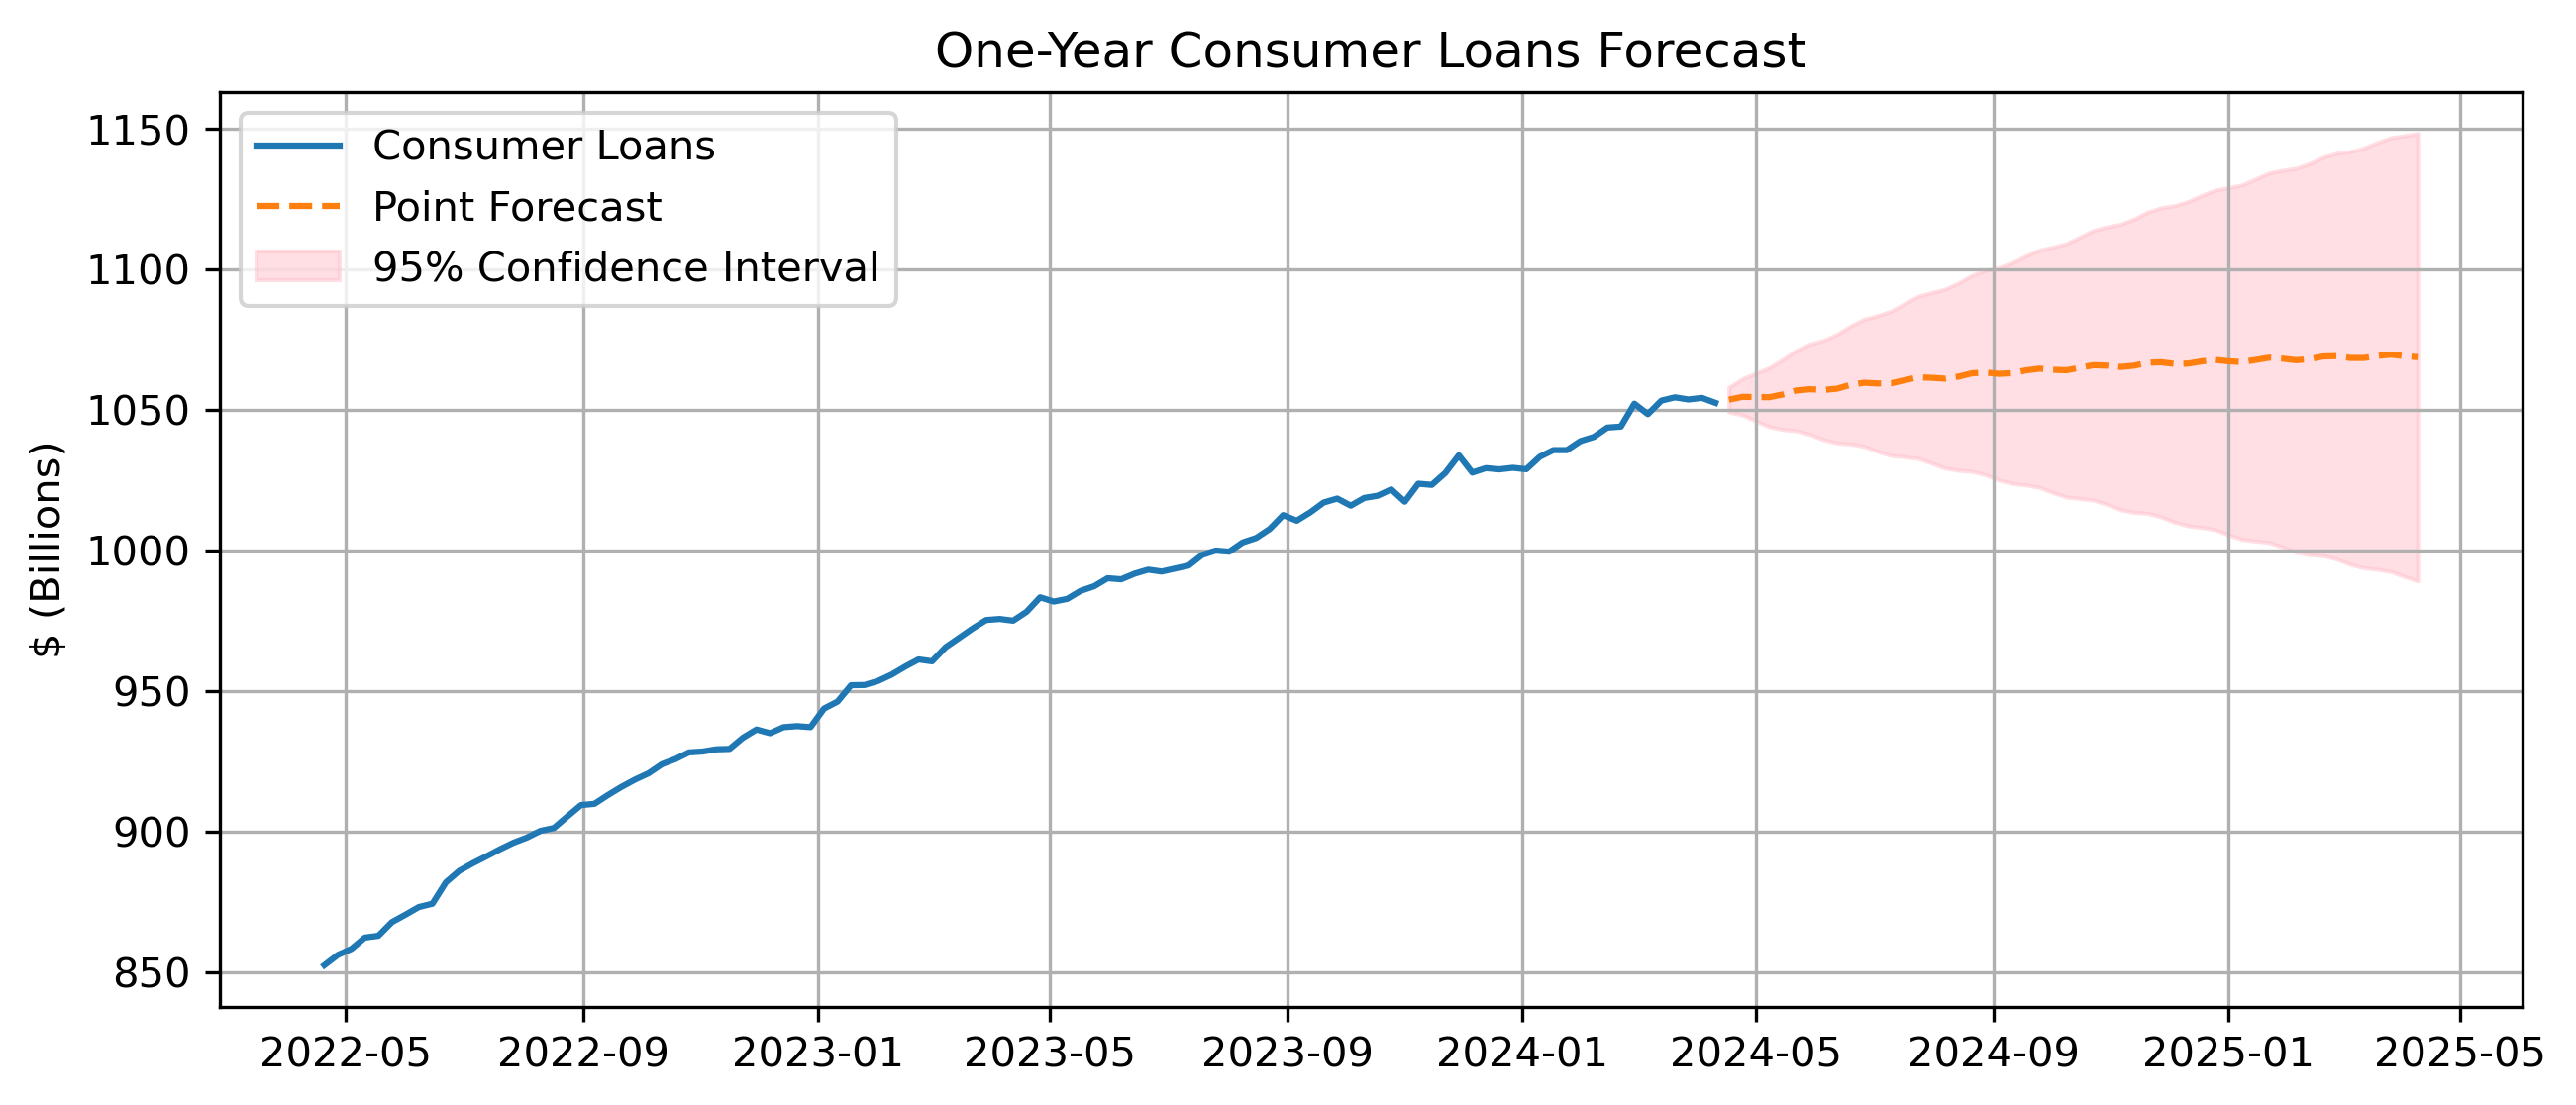

In [24]:
alpha = 0.05

plt.figure(figsize=(10,4), dpi=300)
plt.plot(loans[-104:], label="Consumer Loans")

fc = (
    arimax_results[3, 6]
    .get_forecast(steps=52, exog=exog_forecast)
    .summary_frame(alpha=alpha)
)

plt.plot(fc["mean"], linestyle="dashed", label="Point Forecast")

plt.fill_between(
    fc.index,
    fc.mean_ci_upper,
    fc.mean_ci_lower,
    color="pink",
    alpha=0.5,
    label=f"{((1 - alpha) * 100):.0f}% Confidence Interval",
)

plt.legend(loc="upper left")
plt.title("One-Year Consumer Loans Forecast")
plt.ylabel('$ (Billions)')
plt.grid()

In [14]:
fc

loans,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-17,1053.741152,2.227135,1049.376048,1058.106256
2024-04-24,1054.733904,3.282410,1048.300499,1061.167310
2024-05-01,1054.665538,4.334070,1046.170917,1063.160158
2024-05-08,1054.612829,5.365616,1044.096416,1065.129243
2024-05-15,1055.600951,6.348869,1043.157396,1068.044506
2024-05-22,1057.011173,7.301117,1042.701246,1071.321099
2024-05-29,1057.449742,8.186245,1041.404997,1073.494488
2024-06-05,1057.189617,9.017297,1039.516039,1074.863194
2024-06-12,1057.640075,9.848577,1038.337218,1076.942931
2024-06-19,1058.992056,10.696481,1038.027339,1079.956772


Making one step ahead


In [15]:
# getting most recent value for deposits
deposits_log_ret = np.log(arimax_df["deposits_l1"]).diff().bfill()
deposits_log_ret

exog_forecast1 = np.zeros((1, 2))
exog_forecast1[0, 0] = ieffr["Implied EFFR"].values[0]
exog_forecast1[0, 1] = deposits_log_ret[-1]

fc1 = arimax_results[3, 6].get_forecast(steps=1, exog=exog_forecast1).summary_frame()
fc1

loans,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-17,1053.876844,2.227135,1049.51174,1058.241948
